In [328]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_parquet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE

In [329]:
dataframe = read_parquet('kline_data/kline_data/train_data/1000FLOKIUSDT.parquet')
dataframe.head(5)

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount
0,1683390600000,0.0423100,0.0444600,0.0423100,0.0432000,91614205,3986427.2652500,16405,46218295,2010734.9819600
1,1683391500000,0.0431900,0.0437500,0.0428700,0.0433200,61141456,2646329.8671100,11214,31271274,1353742.8878800
2,1683392400000,0.0433200,0.0436500,0.0429000,0.0432000,51385122,2223310.8747900,8909,26248343,1135844.9290600
3,1683393300000,0.0432100,0.0433000,0.0423900,0.0428600,54321490,2329436.1780000,9208,25720153,1103324.2959700
4,1683394200000,0.0428500,0.0434700,0.0426500,0.0429500,37486122,1616366.3676500,7528,18928398,816380.6000400


In [330]:
tf.random.set_seed(2025)

In [331]:
dataframe = dataframe.astype(np.float32)

In [332]:
dataframe['feature0'] = (dataframe['close_price'] - dataframe['open_price']) / dataframe['open_price']
dataframe['feature1'] = (dataframe['high_price'] - dataframe['low_price']) / dataframe['close_price']
dataframe['feature2'] = dataframe['buy_volume'] / (dataframe['volume'] - dataframe['buy_volume'])
dataframe['feature3'] = dataframe['amount'] / dataframe['volume']
dataframe['feature4'] = dataframe['buy_amount'] / dataframe['buy_volume']

In [333]:
dataframe['rolling_max'] = dataframe['high_price'].expanding(min_periods=1).max()
dataframe['rolling_min'] = dataframe['low_price'].expanding(min_periods=1).min()
for window in [3, 6, 9, 12, 15]:
    dataframe[f'sma_{window}'] = dataframe['close_price'].expanding(min_periods=1).mean()
    if window > 1:
        # 从第window个位置开始使用滚动平均值
        dataframe[f'sma_{window}'].iloc[window-1:] = dataframe['close_price'].rolling(window=window).mean().iloc[window-1:]
    
     # 2. 移动波动率 (N周期内最高价与最低价之差)
    # 使用累积最大值/最小值填充初始值
    
    dataframe[f'rolling_volatility_{window}'] = (dataframe['rolling_max'] - dataframe['rolling_min']) / dataframe['close_price']
    if window > 1:
        # 从第window个位置开始使用滚动窗口计算
        rolling_max = dataframe['high_price'].rolling(window=window).max()
        rolling_min = dataframe['low_price'].rolling(window=window).min()
        valid_indices = rolling_max.index[window-1:]
        dataframe.loc[valid_indices, f'rolling_volatility_{window}'] = (
            (rolling_max - rolling_min) / dataframe['close_price']
        ).loc[valid_indices]
    
    # 3. 量能变化率 (当前成交量与前一期成交量变化率)
    dataframe[f'volume_change_{window}'] = 0.0  # 初始化
    # 从第二个数据点开始计算
    if len(dataframe) > 1:
        prev_volume = dataframe['volume'].shift(window)
        volume_change = (dataframe['volume'] - prev_volume) / prev_volume.replace(0, 1)
        dataframe[f'volume_change_{window}'].iloc[1:] = volume_change.iloc[1:]
    
    # 4. 价格-量能背离指标
    dataframe[f'divergence_{window}'] = 0.0  # 初始化
    # 从第二个数据点开始计算
    if len(dataframe) > 1:
        # 价格变化方向 (1=上涨, -1=下跌)
        price_dir = np.sign(dataframe['close_price'] - dataframe['close_price'].shift(window))
        # 量能变化方向 (1=增加, -1=减少)
        volume_dir = np.sign(dataframe['volume'] - dataframe['volume'].shift(window))
        dataframe[f'divergence_{window}'].iloc[1:] = price_dir.iloc[1:] * volume_dir.iloc[1:]

C:\Users\41582\AppData\Local\Temp\ipykernel_9988\2676571283.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataframe[f'sma_{window}'].iloc[window-1:] = dataframe['close_price'].rolling(window=window).mean().iloc[window-1:]
C:\Users\4158

In [334]:
dataframe.describe()

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,...,volume_change_9,divergence_9,sma_12,rolling_volatility_12,volume_change_12,divergence_12,sma_15,rolling_volatility_15,volume_change_15,divergence_15
count,5.807800e+04,58078.000000,58078.000000,58078.000000,58078.000000,5.807800e+04,5.807800e+04,58078.000000,5.807800e+04,5.807800e+04,...,58070.000000,58070.000000,58078.000000,58078.000000,58067.000000,58067.000000,58078.000000,58078.000000,58064.000000,58064.000000
mean,1.709525e+12,0.104374,0.104966,0.103785,0.104376,1.334458e+07,1.572438e+06,7152.956055,6.535440e+06,7.686268e+05,...,0.596686,0.044326,0.104363,0.034317,0.616816,0.043450,0.104359,0.038620,0.672912,0.055835
std,1.508987e+10,0.083461,0.084022,0.082907,0.083461,3.043106e+07,3.500511e+06,12862.773438,1.532683e+07,1.735618e+06,...,8.458428,0.993858,0.083444,0.029448,5.244167,0.994745,0.083440,0.032638,5.805912,0.994491
min,1.683391e+12,0.015330,0.015380,0.015120,0.015330,6.806100e+04,1.612593e+03,37.000000,2.335600e+04,3.687912e+02,...,-0.981248,-1.000000,0.015397,0.003169,-0.987204,-1.000000,0.015399,0.003578,-0.997373,-1.000000
25%,1.696458e+12,0.028430,0.028550,0.028320,0.028433,3.255002e+06,1.128216e+05,803.000000,1.556360e+06,5.398098e+04,...,-0.417156,-1.000000,0.028457,0.017345,-0.428465,-1.000000,0.028460,0.019553,-0.437581,-1.000000
50%,1.709525e+12,0.113255,0.113715,0.112655,0.113260,6.187208e+06,5.545940e+05,3185.500000,2.983830e+06,2.684660e+05,...,-0.029904,1.000000,0.113268,0.026078,-0.027163,1.000000,0.113261,0.029605,-0.028217,1.000000
75%,1.722593e+12,0.171898,0.172770,0.171077,0.171900,1.261780e+07,1.624687e+06,8167.750000,6.163021e+06,7.898633e+05,...,0.660808,1.000000,0.171955,0.041064,0.688093,1.000000,0.171976,0.046185,0.725080,1.000000
max,1.735660e+12,0.345020,0.349290,0.340230,0.345090,1.323368e+09,1.576538e+08,425066.000000,7.153520e+08,7.900835e+07,...,1585.897705,1.000000,0.334487,0.527254,429.845551,1.000000,0.333475,0.539832,749.621582,1.000000


In [335]:
dataframe.drop(columns=['rolling_max'], inplace=True)
dataframe.drop(columns=['rolling_min'], inplace=True)

In [336]:
dataframe = dataframe.dropna(axis=0)

In [337]:
# 1. 检查整个数据集是否有NaN
print("数据集是否包含NaN:", dataframe.isnull().values.any())

# 2. 统计每列的NaN数量
nan_counts = dataframe.isnull().sum()
print("\n各列NaN值统计:")
print(nan_counts)

# 3. 查看NaN值占比
nan_percent = dataframe.isnull().mean() * 100
print("\n各列NaN值占比(%):")
print(nan_percent.round(2))

数据集是否包含NaN: False

各列NaN值统计:
timestamp                0
open_price               0
high_price               0
low_price                0
close_price              0
volume                   0
amount                   0
count                    0
buy_volume               0
buy_amount               0
feature0                 0
feature1                 0
feature2                 0
feature3                 0
feature4                 0
sma_3                    0
rolling_volatility_3     0
volume_change_3          0
divergence_3             0
sma_6                    0
rolling_volatility_6     0
volume_change_6          0
divergence_6             0
sma_9                    0
rolling_volatility_9     0
volume_change_9          0
divergence_9             0
sma_12                   0
rolling_volatility_12    0
volume_change_12         0
divergence_12            0
sma_15                   0
rolling_volatility_15    0
volume_change_15         0
divergence_15            0
dtype: int64

各列NaN值占比(%):

In [338]:
dataset = dataframe.values
dataset = np.delete(dataset, 0, axis=1)
dataset = dataset.astype('float32')

In [339]:
diff = np.full((len(dataset)), np.nan)
diff[1:] = dataset[1:, 3] - dataset[:-1, 3]
diff[0] = 0
terciles = np.percentile(diff, [33.3, 66.7])
print("第一个三分位点 (33.3%):", terciles[0])
print("第二个三分位点 (66.7%):", terciles[1])
y = np.full((len(dataset)), np.nan)
for i in range(len(dataset) - 1):
    y[i + 1] = 0 if diff[i + 1] < - 2.5e-04 else (1 if diff[i + 1] < 2.5e-04 else 2)
y[0] = 0
print(y[:5])

第一个三分位点 (33.3%): -8.999928832054138e-05
第二个三分位点 (66.7%): 8.00006091594696e-05
[0. 0. 1. 1. 0.]


In [340]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [341]:
print(dataset[:5])

[[8.1834450e-02 8.7089330e-02 8.3633237e-02 8.4516011e-02 6.9180198e-02
  2.5275992e-02 3.8510315e-02 6.4578630e-02 2.5445102e-02 6.6511148e-01
  1.1001364e-01 3.6806908e-02 8.5776582e-02 8.5735321e-02 8.5276067e-02
  1.0593498e-01 1.1002596e-03 5.0000000e-01 8.6343363e-02 1.0039167e-01
  9.6275908e-04 5.0000000e-01 8.6850613e-02 9.4253510e-02 6.1835081e-04
  5.0000000e-01 8.7133206e-02 8.8916838e-02 2.2913856e-03 5.0000000e-01
  8.7402597e-02 8.6135611e-02 1.3287335e-03 5.0000000e-01]
 [7.7739693e-02 7.7356160e-02 7.7512242e-02 7.5994663e-02 2.3064196e-02
  7.8924643e-03 1.3956696e-02 2.1622434e-02 7.9844082e-03 5.7075560e-01
  4.7969759e-02 3.7111316e-02 7.7305987e-02 7.7342227e-02 7.7872753e-02
  7.3481672e-02 1.2260093e-03 0.0000000e+00 7.9964608e-02 1.7348754e-01
  1.0000891e-03 0.0000000e+00 8.1940755e-02 1.6785981e-01 4.8528850e-04
  1.0000000e+00 8.3458684e-02 1.8150331e-01 1.2773235e-03 1.0000000e+00
  8.4407493e-02 1.7662100e-01 4.4131686e-04 1.0000000e+00]
 [7.6041125e-02 7.

In [342]:
dataset = dataset[:-1]
y = y[1:]
print(dataset.shape)
print(y.shape)

(58063, 34)
(58063,)


In [343]:
smote = SMOTE(random_state=2025)
dataset_smote, y_smote = smote.fit_resample(dataset, y)

In [344]:
print(dataset_smote.shape)
print(y_smote.shape)

(96384, 34)
(96384,)


In [345]:
X_train, X_test, y_train, y_test = train_test_split(dataset_smote, y_smote, test_size=0.2)

In [346]:
# 构建模型集成
lgbm_model = LGBMClassifier(n_estimators=400, max_depth=10, learning_rate=0.5, random_state=2025, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, colsample_bytree=0.8)
xgb_model = XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.5, random_state=2025, reg_alpha=0.5, reg_lambda=0.5, subsample=0.8, colsample_bytree=0.8)
catboost_model = CatBoostClassifier(n_estimators=400, max_depth=10, learning_rate=0.5, random_state=2025, verbose=0, l2_leaf_reg=3, rsm=0.8) # 构建基模型，并加入正则化和降低复杂度

# 集成模型：StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('lgbm', lgbm_model), ('xgb', xgb_model), ('catboost', catboost_model)],
    final_estimator=LGBMClassifier(n_estimators=25, random_state=2025)
)

In [347]:
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7516
[LightGBM] [Info] Number of data points in the train set: 77107, number of used features: 34
[LightGBM] [Info] Start training from score -1.099559
[LightGBM] [Info] Start training from score -1.096604
[LightGBM] [Info] Start training from score -1.099676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7490
[LightGBM] [Info] Number of data points in the train set: 61685, number of used features: 34
[LightGBM] [Info] Start training from score -1.099569
[LightGBM] [Info] Start training from score -1.096604
[LightGBM] [Info] Start training from score -1.099667


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7494
[LightGBM] [Info] Number of data points in the train set: 61685, number of used features: 34
[LightGBM] [Info] Start training from score -1.099569
[LightGBM] [Info] Start training from score -1.096604
[LightGBM] [Info] Start training from score -1.099667


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7493
[LightGBM] [Info] Number of data points in the train set: 61686, number of used features: 34
[LightGBM] [Info] Start training from score -1.099537
[LightGBM] [Info] Start training from score -1.096620
[LightGBM] [Info] Start training from score -1.099683


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7493
[LightGBM] [Info] Number of data points in the train set: 61686, number of used features: 34
[LightGBM] [Info] Start training from score -1.099537
[LightGBM] [Info] Start training from score -1.096620
[LightGBM] [Info] Start training from score -1.099683


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7495
[LightGBM] [Info] Number of data points in the train set: 61686, number of used features: 34
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096572
[LightGBM] [Info] Start training from score -1.099683


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 77107, number of used features: 9
[LightGBM] [Info] Start training from score -1.099559
[LightGBM] [Info] Start training from score -1.096604
[LightGBM] [Info] Start training from score -1.099676


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(colsample_bytree=0.8,
                                               learning_rate=0.5, max_depth=10,
                                               n_estimators=400,
                                               random_state=2025, reg_alpha=0.5,
                                               reg_lambda=0.5, subsample=0.8)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x00000296DF4CD5E0>)],
                   final_estimator=LGBMClassifier(n_estimators=25,
                                                  random_state=2025))

In [348]:
y_pred = stacking_model.predict(X_test)

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [349]:
print(y_pred[:5])

[1. 2. 2. 2. 2.]


In [350]:
print("分类报告：")
print(classification_report(y_test, y_pred, target_names=["下跌", "不变", "上涨"]))

分类报告：
              precision    recall  f1-score   support

          下跌       0.74      0.77      0.75      6450
          不变       0.88      0.81      0.84      6374
          上涨       0.75      0.77      0.76      6453

    accuracy                           0.78     19277
   macro avg       0.79      0.78      0.78     19277
weighted avg       0.79      0.78      0.78     19277



In [351]:
y_pred_train = stacking_model.predict(X_train)

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [352]:
print("分类报告：")
print(classification_report(y_train, y_pred_train, target_names=["下跌", "不变", "上涨"]))

分类报告：
              precision    recall  f1-score   support

          下跌       1.00      1.00      1.00     25678
          不变       1.00      1.00      1.00     25754
          上涨       1.00      1.00      1.00     25675

    accuracy                           1.00     77107
   macro avg       1.00      1.00      1.00     77107
weighted avg       1.00      1.00      1.00     77107



In [353]:
y_pred_primitive = stacking_model.predict(dataset)
print("分类报告：")
print(classification_report(y, y_pred_primitive, target_names=["Going down", "Almost unchanged", "Going up"]))

D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


分类报告：
                  precision    recall  f1-score   support

      Going down       0.91      0.94      0.93     13302
Almost unchanged       0.98      0.96      0.97     32128
        Going up       0.91      0.93      0.92     12633

        accuracy                           0.95     58063
       macro avg       0.94      0.95      0.94     58063
    weighted avg       0.95      0.95      0.95     58063



D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [354]:
print(len(dataset))
y_1 = np.full(len(dataset) + 1, np.nan)
y_1[1:] = y
y_1[0] = 0
dataframe['real_label'] = y_1
dataframe.describe()
dataframe.head(5)

58063


,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,...,divergence_9,sma_12,rolling_volatility_12,volume_change_12,divergence_12,sma_15,rolling_volatility_15,volume_change_15,divergence_15,real_label
0,1.683391e+12,0.04231,0.04446,0.04231,0.04320,91614208.0,3.986427e+06,16405.0,46218296.0,2.010735e+06,...,0.0,0.043200,0.049768,0.000000,0.0,0.043200,0.049768,0.000000,0.0,0.0
15,1.683404e+12,0.04096,0.04121,0.04032,0.04039,30588908.0,1.245877e+06,5969.0,15490502.0,6.312008e+05,...,1.0,0.042028,0.098292,-0.436891,1.0,0.042247,0.098292,-0.666112,1.0,0.0
16,1.683405e+12,0.04040,0.04085,0.04028,0.04061,16271016.0,6.600976e+05,3463.0,9387666.0,3.809338e+05,...,1.0,0.041833,0.097759,-0.565946,1.0,0.042067,0.097759,-0.733879,1.0,1.0
17,1.683406e+12,0.04063,0.04065,0.04015,0.04047,15432127.0,6.238319e+05,2866.0,7487192.0,3.026991e+05,...,1.0,0.041584,0.088955,-0.712845,1.0,0.041885,0.098097,-0.699677,1.0,1.0
18,1.683407e+12,0.04047,0.04048,0.03900,0.03967,62572408.0,2.487198e+06,13248.0,27992306.0,1.112742e+06,...,-1.0,0.041283,0.110663,0.613657,-1.0,0.041672,0.122511,0.151891,-1.0,0.0


In [41]:
y_2 = np.full(len(dataset) + 1, np.nan)
y_2[1:] = y_pred_primitive
y_2[0] = 0
dataframe['predict_label'] = y_2
dataframe.describe()
dataframe.head(5)

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,...,sma_12,rolling_volatility_12,volume_change_12,divergence_12,sma_15,rolling_volatility_15,volume_change_15,divergence_15,real_label,predict_label
0,1.683391e+12,0.04231,0.04446,0.04231,0.04320,91614208.0,3986427.250,16405.0,46218296.0,2010735.000,...,0.043200,0.049768,0.000000,0.0,0.043200,0.049768,0.000000,0.0,0.0,0.0
1,1.683392e+12,0.04319,0.04375,0.04287,0.04332,61141456.0,2646329.750,11214.0,31271274.0,1353742.875,...,0.043260,0.049631,-0.332620,-1.0,0.043260,0.049631,-0.332620,-1.0,1.0,1.0
2,1.683392e+12,0.04332,0.04365,0.04290,0.04320,51385120.0,2223310.750,8909.0,26248344.0,1135844.875,...,0.043240,0.049768,-0.159570,1.0,0.043240,0.049768,-0.159570,1.0,1.0,1.0
3,1.683393e+12,0.04321,0.04330,0.04239,0.04286,54321488.0,2329436.250,9208.0,25720152.0,1103324.250,...,0.043145,0.050163,0.057144,-1.0,0.043145,0.050163,0.057144,-1.0,0.0,0.0
4,1.683394e+12,0.04285,0.04347,0.04265,0.04295,37486120.0,1616366.375,7528.0,18928398.0,816380.625,...,0.043106,0.050058,-0.309921,-1.0,0.043106,0.050058,-0.309921,-1.0,1.0,0.0


In [43]:
dataframe.head(100)

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,...,sma_12,rolling_volatility_12,volume_change_12,divergence_12,sma_15,rolling_volatility_15,volume_change_15,divergence_15,real_label,predict_label
0,1.683391e+12,0.04231,0.04446,0.04231,0.04320,91614208.0,3.986427e+06,16405.0,46218296.0,2.010735e+06,...,0.043200,0.049768,0.000000,0.0,0.043200,0.049768,0.000000,0.0,0.0,0.0
1,1.683392e+12,0.04319,0.04375,0.04287,0.04332,61141456.0,2.646330e+06,11214.0,31271274.0,1.353743e+06,...,0.043260,0.049631,-0.332620,-1.0,0.043260,0.049631,-0.332620,-1.0,1.0,1.0
2,1.683392e+12,0.04332,0.04365,0.04290,0.04320,51385120.0,2.223311e+06,8909.0,26248344.0,1.135845e+06,...,0.043240,0.049768,-0.159570,1.0,0.043240,0.049768,-0.159570,1.0,1.0,1.0
3,1.683393e+12,0.04321,0.04330,0.04239,0.04286,54321488.0,2.329436e+06,9208.0,25720152.0,1.103324e+06,...,0.043145,0.050163,0.057144,-1.0,0.043145,0.050163,0.057144,-1.0,0.0,0.0
4,1.683394e+12,0.04285,0.04347,0.04265,0.04295,37486120.0,1.616366e+06,7528.0,18928398.0,8.163806e+05,...,0.043106,0.050058,-0.309921,-1.0,0.043106,0.050058,-0.309921,-1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.683476e+12,0.04002,0.04023,0.03961,0.03979,20985024.0,8.365750e+05,3607.0,10470640.0,4.173861e+05,...,0.040509,0.058055,0.270925,-1.0,0.040379,0.064840,0.270925,-1.0,0.0,0.0
96,1.683477e+12,0.03979,0.03994,0.03936,0.03959,25827532.0,1.024946e+06,4432.0,12051447.0,4.784458e+05,...,0.040429,0.064663,0.230760,-1.0,0.040343,0.064663,0.230760,-1.0,0.0,0.0
97,1.683478e+12,0.03959,0.03967,0.03935,0.03955,29360768.0,1.159531e+06,4024.0,14719033.0,5.814833e+05,...,0.040325,0.064981,0.136801,-1.0,0.040329,0.064981,0.136801,-1.0,1.0,1.0
98,1.683479e+12,0.03958,0.04012,0.03958,0.03978,22266216.0,8.882010e+05,4064.0,12131679.0,4.841352e+05,...,0.040158,0.064605,-0.241634,-1.0,0.040335,0.064605,-0.241634,-1.0,2.0,2.0


In [45]:
dataframe[['open_price', 'close_price', 'high_price', 'low_price', 'volume', 'real_label', 'predict_label']].to_csv('data.csv', index=True)

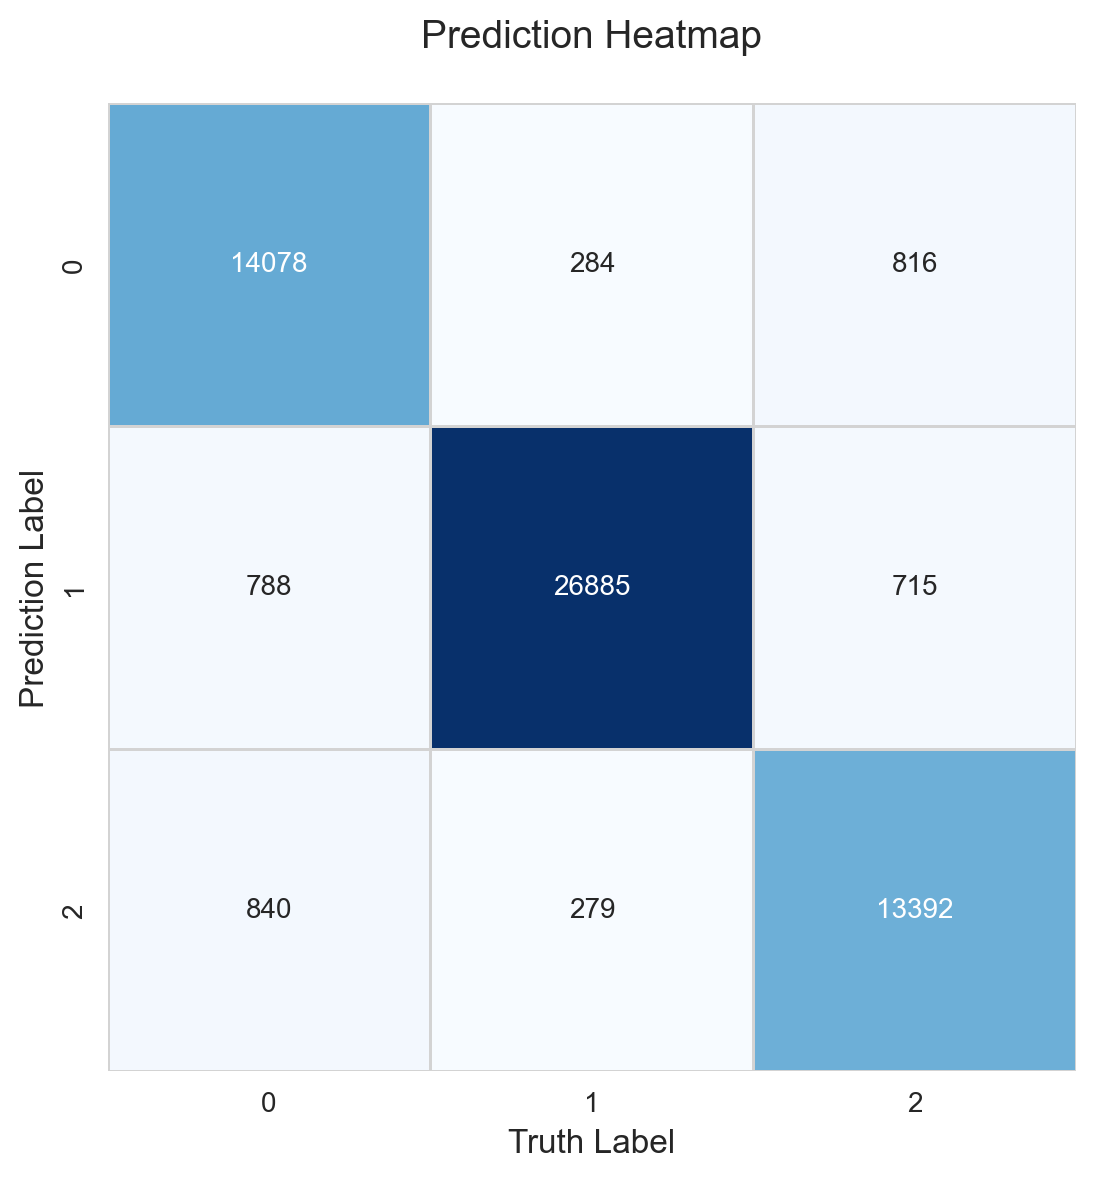

In [48]:
plt.figure(figsize=(8, 6), dpi=200)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred_primitive, labels=[0, 1, 2])

# 使用 Seaborn 绘制热力图
ax = sns.heatmap(
    conf_matrix,
    annot=True,              # 在单元格中显示数值
    fmt="d",                 # 整数格式
    cmap=plt.cm.Blues,       # 颜色映射
    linewidths=0.5,          # 单元格间线宽
    linecolor="lightgray",   # 单元格间线颜色
    cbar=False,              # 不显示颜色条
    xticklabels=["0", "1", "2"],
    yticklabels=["0", "1", "2"],
    square = True
)

# 设置标签和标题
plt.title('Prediction Heatmap', fontsize=14, pad=20)
plt.xlabel('Truth Label', fontsize=12)
plt.ylabel('Prediction Label', fontsize=12)

# 设置刻度字体大小
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()